In [4]:
import skimage.data
import numpy as np
import sys

In [20]:
#The pooling layer is used to reduce the dimensions of the feature maps.
def pooling(feature_map, size=2, stride=2):
    # Preparing the output of the pooling operation.
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride),
                            np.uint16((feature_map.shape[1]-size+1)/stride),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0, feature_map.shape[0]-size-1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size-1, stride):
                pool_out[r2, c2, map_num] = np.max(feature_map[r:r+size,  c:c+size])
                c2 = c2 + 1
            r2 = r2 + 1
    return pool_out


In [16]:
#The relu activation function will set all negative values in the feature map to 0.
def relu(feature_map):
    # Preparing the output of the ReLU activation function.
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0, feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max(feature_map[r, c, map_num], 0)
    return relu_out


In [6]:
#Convolution is performed by sliding the filters over the input image and creating feature maps that give the responses of the filters at each location.
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[0]
    result = np.zeros((img.shape))
    # Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2,
                                        img.shape[0]-filter_size/2-2)):
        for c in np.uint16(np.arange(filter_size/2, img.shape[1]-filter_size/2-2)):
            # Getting the current region to get multiplied with the filter.
            curr_region = img[r:r+filter_size, c:c+filter_size]
            # Element-wise multiplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) # Summing the result of multiplication.
            result[r, c] = conv_sum # Saving the summation in the convolution layer feature map.

    # Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2):result.shape[0]-np.uint16(filter_size/2),
                          np.uint16(filter_size/2):result.shape[1]-np.uint16(filter_size/2)]
    return final_result

#The convolution function checks that the filter depth is correct for the given image, and then calls the conv_ function to convole the image with each filter in the filter bank.
def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1] % 2 == 0: # Check if filter dimensions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0] - conv_filter.shape[1] + 1,
                                img.shape[1] - conv_filter.shape[1] + 1,
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """
        Checking if there are multiple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num],
                                           curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.



### Reads in the image

In [5]:
# Reading the image  
img = skimage.data.chelsea()  
# Converting the image into gray.  
img = skimage.color.rgb2gray(img)

In [7]:
#Preparing the filters
l1_filter = np.zeros((2,3,3))


#These are the actual filters to be applied to each image when creating a feature map
l1_filter[0, :, :] = np.array([[[-1, 0, 1],   
                                     [-1, 0, 1],   
                                     [-1, 0, 1]]])

l1_filter[1, :, :] = np.array([[[1,   1,  1],   
                                     [0,   0,  0],   
                                     [-1, -1, -1]]]) 

In [9]:
#Calls the convolution function on the image with the given filters
l1_feature_map = conv(img, l1_filter)  

Filter  1
Filter  2


In [17]:
#Performs ReLU activation on the feature map
l1_feature_map_relu = relu(l1_feature_map)

In [21]:
#Reduces the dimensionality of the feature map by pooling each feature map with a 2x2 filter
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)  

In [22]:
# Applying more convolution layers
l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 2**")
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
print("\n**ReLU**")
l2_feature_map_relu = relu(l2_feature_map)
print("\n**Pooling**")
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
print("**End of conv layer 2**\n")



**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**



In [26]:
#Applying more convolution layers
l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 3**")
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
print("\n**ReLU**")
l3_feature_map_relu = relu(l3_feature_map)
print("\n**Pooling**")
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)
print("**End of conv layer 3**\n")



**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



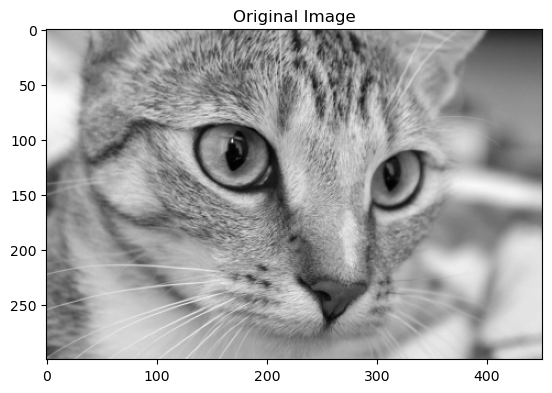

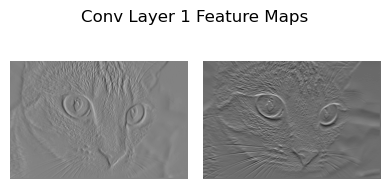

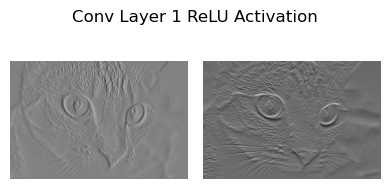

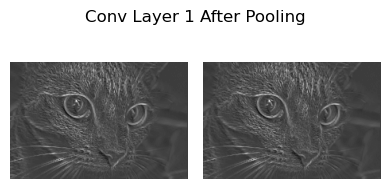

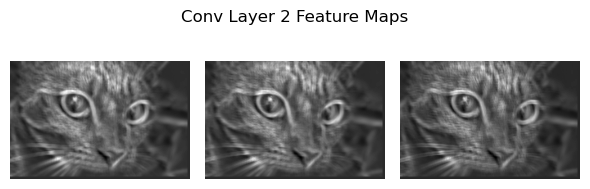

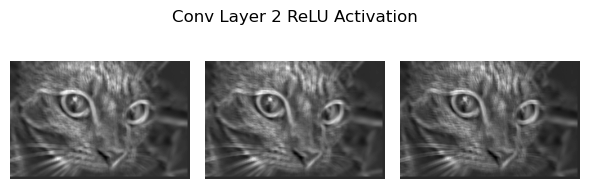

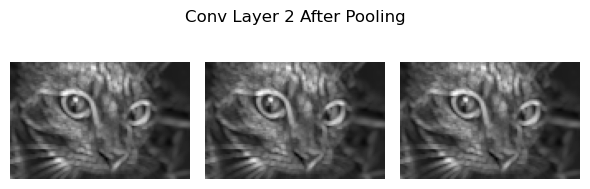

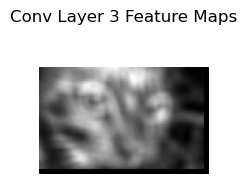

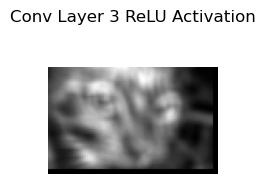

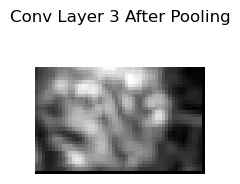

In [28]:
import matplotlib.pyplot as plt
import os

# Create the folder if it doesn't exist
if not os.path.exists('problem4'):
    os.makedirs('problem4')

#Function to create output plots of each arrays and save them
def plot_feature_maps(feature_maps, title, filename):
    num_maps = feature_maps.shape[-1]
    fig, axes = plt.subplots(1, num_maps, figsize=(num_maps * 2, 2))
    axes = np.atleast_1d(axes)  # Ensure that axes is always an array
    for i in range(num_maps):
        axes[i].imshow(feature_maps[..., i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f'problem4/{filename}.png')
    plt.show()

# Plot original image
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.savefig('problem4/original_image.png')
plt.show()

# Plot feature maps
plot_feature_maps(l1_feature_map, 'Conv Layer 1 Feature Maps', 'conv_layer_1')
plot_feature_maps(l1_feature_map_relu, 'Conv Layer 1 ReLU Activation', 'relu_layer_1')
plot_feature_maps(l1_feature_map_relu_pool, 'Conv Layer 1 After Pooling', 'pool_layer_1')

plot_feature_maps(l2_feature_map, 'Conv Layer 2 Feature Maps', 'conv_layer_2')
plot_feature_maps(l2_feature_map_relu, 'Conv Layer 2 ReLU Activation', 'relu_layer_2')
plot_feature_maps(l2_feature_map_relu_pool, 'Conv Layer 2 After Pooling', 'pool_layer_2')

plot_feature_maps(l3_feature_map, 'Conv Layer 3 Feature Maps', 'conv_layer_3')
plot_feature_maps(l3_feature_map_relu, 'Conv Layer 3 ReLU Activation', 'relu_layer_3')
plot_feature_maps(l3_feature_map_relu_pool, 'Conv Layer 3 After Pooling', 'pool_layer_3')
